In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 416 
CHANNELS=3
EPOCHS=19

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Cinnaman_images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1137 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['healthy_leaves', 'leaf_spot_disease']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 416, 416, 3)
[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0]


plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

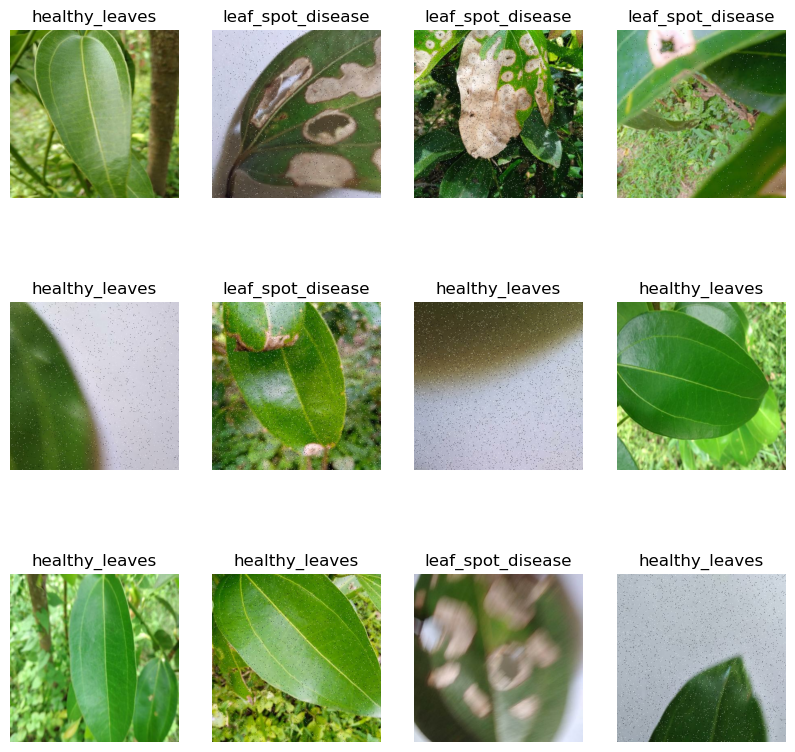

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

36

In [8]:
train_size = 0.8
len(dataset)*train_size

28.8

In [9]:
train_ds = dataset.take(28)
len(train_ds)

28

In [10]:
test_ds = dataset.skip(28)
len(test_ds)

8

In [11]:
val_size=0.1
len(dataset)*val_size

3.6

In [12]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [13]:
test_ds = test_ds.skip(3)
len(test_ds)

5

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

28

In [17]:
len(val_ds)

3

In [18]:
len(test_ds)

5

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
#data_augmentation = tf.keras.Sequential([
 # layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  #layers.experimental.preprocessing.RandomRotation(0.2),
#])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (x, y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 416, 416, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 414, 414, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 207, 207, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 205, 205, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 102, 102, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 100, 100, 64)       

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=19,
)

Epoch 1/19


28/28 [==============================] - 42s 1s/step - loss: 0.6378 - accuracy: 0.6250 - val_loss: 0.5894 - val_accuracy: 0.6875
Epoch 2/19
28/28 [==============================] - 41s 1s/step - loss: 0.5198 - accuracy: 0.7667 - val_loss: 0.4741 - val_accuracy: 0.8125
Epoch 3/19
28/28 [==============================] - 41s 1s/step - loss: 0.4608 - accuracy: 0.7924 - val_loss: 0.4272 - val_accuracy: 0.7812
Epoch 4/19
28/28 [==============================] - 40s 1s/step - loss: 0.3848 - accuracy: 0.8359 - val_loss: 0.3367 - val_accuracy: 0.8125
Epoch 5/19
28/28 [==============================] - 41s 1s/step - loss: 0.3581 - accuracy: 0.8438 - val_loss: 0.3202 - val_accuracy: 0.8542
Epoch 6/19
28/28 [==============================] - 41s 1s/step - loss: 0.2938 - accuracy: 0.8728 - val_loss: 0.2998 - val_accuracy: 0.8646
Epoch 7/19
28/28 [==============================] - 41s 1s/step - loss: 0.2976 - accuracy: 0.8761 - val_loss: 0.2535 - val_accuracy: 0.8750
Epoch 8/19
28/28 [

In [27]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 2s 325ms/step - loss: 0.0516 - accuracy: 0.9812


In [28]:
scores

[0.05157499760389328, 0.981249988079071]

In [29]:
history.params

{'verbose': 1, 'epochs': 19, 'steps': 28}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

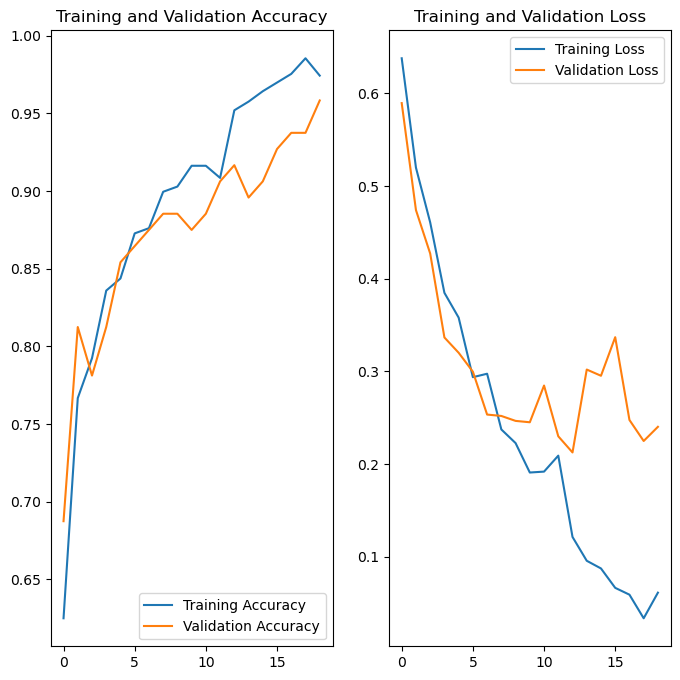

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: leaf_spot_disease
1/1 [==============================] - 0s 469ms/step
predicted label: leaf_spot_disease


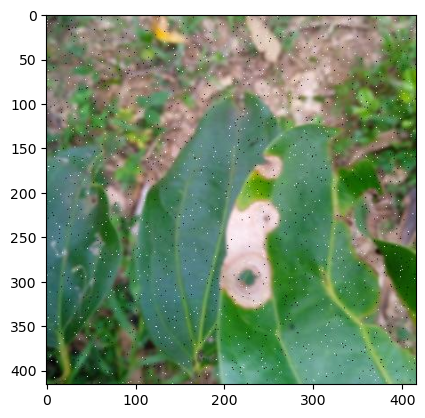

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


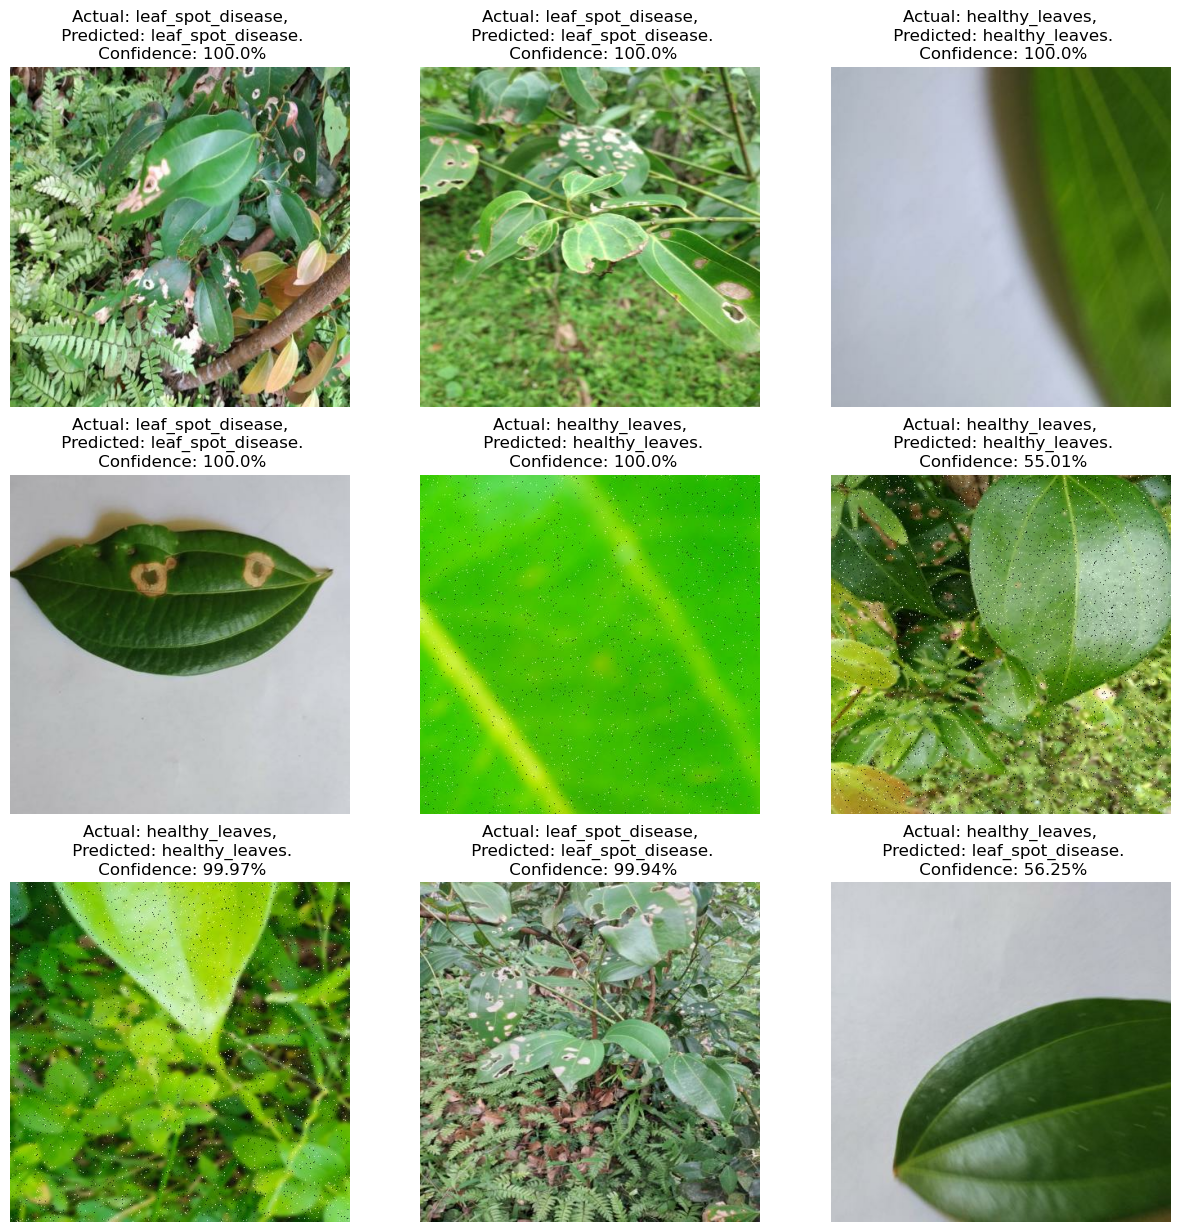

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
from keras.models import save_model

# Assuming 'model' is your Keras model
model_version = 5# Change this as per your versioning logic
save_model(model, f"Cinnamon_models/{model_version}.h5")


C:\Users\Kusal\AppData\Local\Temp\ipykernel_8428\3732856303.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, f"Cinnamon_models/{model_version}.h5")
